In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, when, count 
from pyspark.pandas import DataFrame

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder

c:\Users\Haitheone\.conda\envs\radar\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## General Information ##

In [3]:
sess = SparkSession.builder.appName("FlightDelayEDA").getOrCreate()

In [4]:
df = sess.read.csv('flight_delay_predict.csv', header=True, inferSchema=True)

In [5]:
df.printSchema()
df.show(5)

root
 |-- is_delay: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)

+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+-----

In [6]:
# get shape of the data
print("The shape of the data is: ", (df.count(), len(df.columns)))

The shape of the data is:  (1635590, 20)


In [7]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
# this dataset has no null values

+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+--------+---------------+-------+
|is_delay|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Reporting_Airline|Origin|OriginState|Dest|DestState|CRSDepTime|Cancelled|Diverted|Distance|DistanceGroup|ArrDelay|ArrDelayMinutes|AirTime|
+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+--------+---------------+-------+
|       0|   0|      0|    0|         0|        0|         0|                0|     0|          0|   0|        0|         0|        0|       0|       0|            0|       0|              0|      0|
+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+--------+---------------+-------+


In [8]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------+-----------+-------+---------+------------------+---------+--------+------------------+------------------+-----------------+------------------+------------------+
|summary|          is_delay|              Year|           Quarter|             Month|        DayofMonth|         DayOfWeek|Reporting_Airline| Origin|OriginState|   Dest|DestState|        CRSDepTime|Cancelled|Diverted|          Distance|     DistanceGroup|         ArrDelay|   ArrDelayMinutes|           AirTime|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------+-----------+-------+---------+------------------+---------+--------+------------------+------------------+-----------------+------------------+------------------+
|  count|           1635590|           1635590|           163559

## EDA ##

In [9]:
pdf = df.toPandas()

In [10]:
label_encoder = LabelEncoder()

pdf["Origin"] = label_encoder.fit_transform(pdf["Origin"])
pdf["Dest"] = label_encoder.fit_transform(pdf["Dest"])

print(pdf.dtypes)

is_delay             float64
Year                   int32
Quarter                int32
Month                  int32
DayofMonth             int32
DayOfWeek              int32
FlightDate            object
Reporting_Airline     object
Origin                 int32
OriginState           object
Dest                   int32
DestState             object
CRSDepTime             int32
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int32
ArrDelay             float64
ArrDelayMinutes      float64
AirTime              float64
dtype: object


In [11]:
avg_delay = df.groupby("Origin").mean("ArrDelayMinutes").orderBy("avg(ArrDelayMinutes)").toPandas()
avg_delay_by_dest = df.groupby("Dest").mean("ArrDelayMinutes").orderBy("avg(ArrDelayMinutes)").toPandas()

# join the two dataframes
avg_delay = avg_delay.merge(
    avg_delay_by_dest, how="inner", left_on="Origin", right_on="Dest"
)

avg_delay.drop("Dest", axis=1, inplace=True)
avg_delay.columns = ["Airport", "Origin", "Destination"]
avg_delay = pd.melt(avg_delay, id_vars="Airport", 
                            value_vars = ['Origin', 'Destination'],
                            var_name='Feature', value_name='ArrDelayMinutes')
bar_plot = px.bar(
    avg_delay,
    x="Airport",
    y="ArrDelayMinutes",
    color = 'Feature', barmode='group',
    title="Average Arrival Delay by Origin and Destination Airport",
    labels={"ArrDelayMinutes": "Average Arrival Delay", "Origin": "Airport Code", "Feature": "Origin/Destination Airport"},
)
bar_plot.update_layout(
    xaxis_title="Origin/Destination Airport", yaxis_title="Average Arrival Delay"
)

bar_plot.show()

In [12]:
pdf["FlightDate"] = pd.to_datetime(pdf["FlightDate"])

avg_delay_month = (
    pdf.groupby(pdf["FlightDate"].dt.month)["is_delay"].mean().reset_index()
)

print(avg_delay_month)
fig = px.bar(
    avg_delay_month,
    x="FlightDate",
    y="is_delay",
    labels={"FlightDate": "Month", "is_delay": "Average Delay"},
    title="Average Delay by Month",
    color='FlightDate'
)
fig.show()

    FlightDate  is_delay
0            1  0.208029
1            2  0.198064
2            3  0.199670
3            4  0.190845
4            5  0.224078
5            6  0.264661
6            7  0.247089
7            8  0.245183
8            9  0.162533
9           10  0.180276
10          11  0.169553
11          12  0.221697


In [13]:
d = df.groupby("Reporting_Airline").sum("is_delay").orderBy("sum(is_delay)").toPandas()
d

,Reporting_Airline,sum(is_delay)
0,OO,24517.0
1,DL,44491.0
2,WN,49357.0
3,UA,102638.0
4,AA,122329.0


In [14]:
delayed_flights = (
    df.groupby("Reporting_Airline").sum("is_delay").orderBy("sum(is_delay)").toPandas()
)

fig = px.bar(
    delayed_flights,
    x="Reporting_Airline",
    y="sum(is_delay)",
    labels={
        "Reporting_Airline": "Airline",
        "sum(is_delay)": "Number of Delayed Flights",
    },
    title="Number of Delayed Flights per Airline",
    color="Reporting_Airline",
)
fig.show()

In [15]:
avg_delay_per_airline = df.groupby("Reporting_Airline").mean("ArrDelayMinutes").orderBy("avg(ArrDelayMinutes)").toPandas()


bar_plot = px.bar(
    avg_delay_per_airline,
    x="Reporting_Airline",
    y="avg(ArrDelayMinutes)",
    title="Average Arrival Delay by Airline",
    color="Reporting_Airline",
)
bar_plot.update_layout(
    xaxis_title="Airline", yaxis_title="Average Arrival Delay"
)

bar_plot.show()

In [16]:
# delay by distance group 
delay_by_distance = df.groupby("DistanceGroup").mean("ArrDelayMinutes").orderBy("avg(ArrDelayMinutes)").toPandas()

line_plot = px.line(
    delay_by_distance.sort_values("DistanceGroup"),
    x="DistanceGroup",
    y="avg(ArrDelayMinutes)",
    title="Average Arrival Delay by Distance Group",
)

line_plot.show()

In [17]:
# delay by state
avg_delay = df.groupby("OriginState").mean("ArrDelayMinutes").orderBy("avg(ArrDelayMinutes)").toPandas()
avg_delay_by_dest = (
    df.groupby("DestState").mean("ArrDelayMinutes").orderBy("avg(ArrDelayMinutes)").toPandas()
)

# join the two dataframes
avg_delay = avg_delay.merge(
    avg_delay_by_dest, how="inner", left_on="OriginState", right_on="DestState"
)

avg_delay.drop("DestState", axis=1, inplace=True)
avg_delay.columns = ["State", "Origin", "Destination"]
avg_delay = pd.melt(
    avg_delay,
    id_vars="State",
    value_vars=["Origin", "Destination"],
    var_name="Feature",
    value_name="ArrDelayMinutes",
)
bar_plot = px.bar(
    avg_delay,
    x="State",
    y="ArrDelayMinutes",
    color="Feature",
    barmode="group",
    title="Average Arrival Delay by Origin and Destination State",
    labels={
        "ArrDelayMinutes": "Average Arrival Delay",
        "Origin": "State Code",
        "Feature": "Origin/Destination State",
    },
)
bar_plot.update_layout(
    xaxis_title="Origin/Destination State", yaxis_title="Average Arrival Delay"
)

bar_plot.show()

In [18]:
print("Number of cancelled flights: ", df.filter(col("Cancelled") == 1).count())
print("Number of diverted flights: ", df.filter(col("Diverted") == 1).count())

Number of cancelled flights:  0
Number of diverted flights:  0


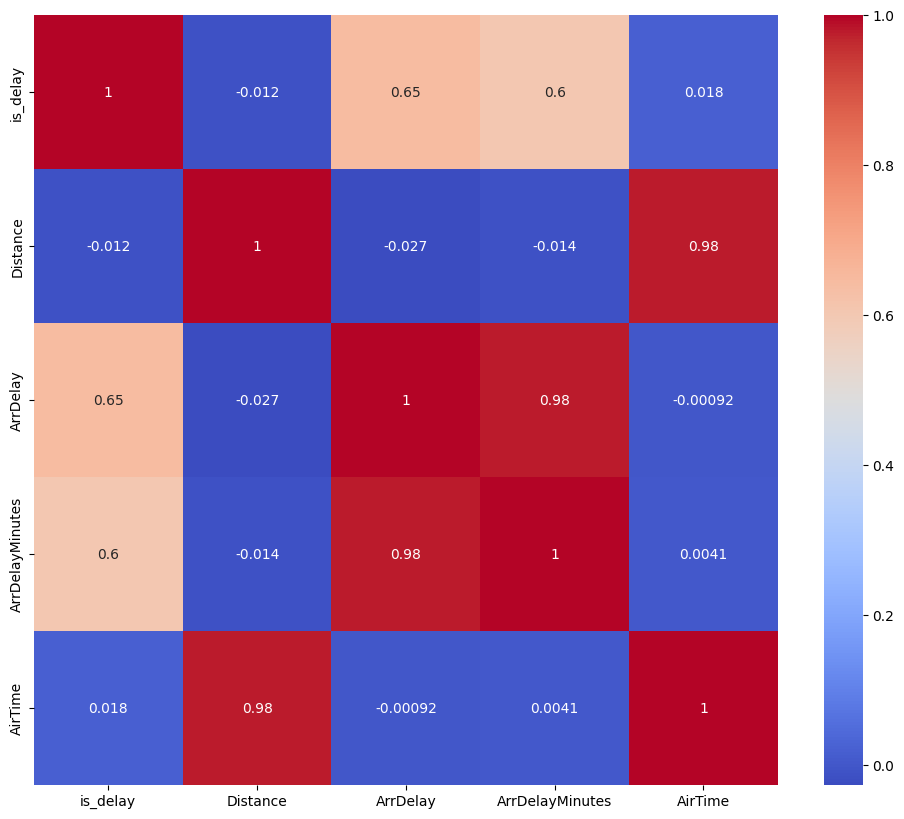

In [19]:
new_pdf = pdf.drop(["Diverted", "Cancelled"], axis=1)
numeric_data = new_pdf.select_dtypes(include=['float64', 'int64'])
corr = numeric_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.savefig("correlation_matrix.png")

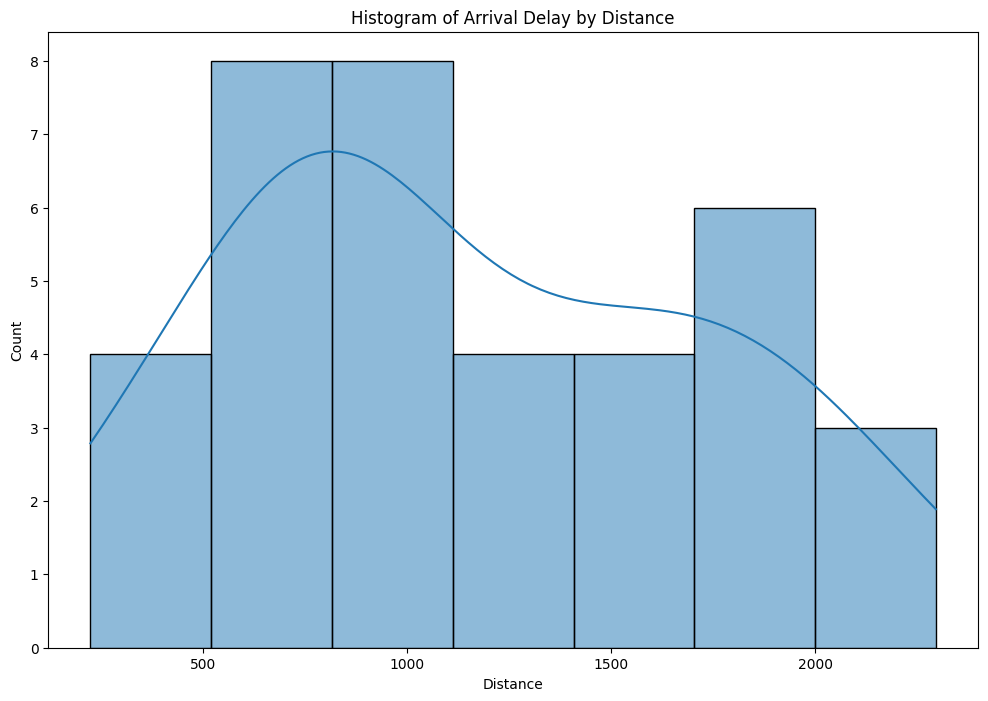

In [20]:
delay_by_distance = df.groupby("Distance").avg("ArrDelayMinutes").orderBy("avg(ArrDelayMinutes)").toPandas()
# hist 
plt.figure(figsize=(12, 8))
plt.title("Histogram of Arrival Delay by Distance")
sns.histplot(data=delay_by_distance, x="Distance", kde=True)
plt.show()

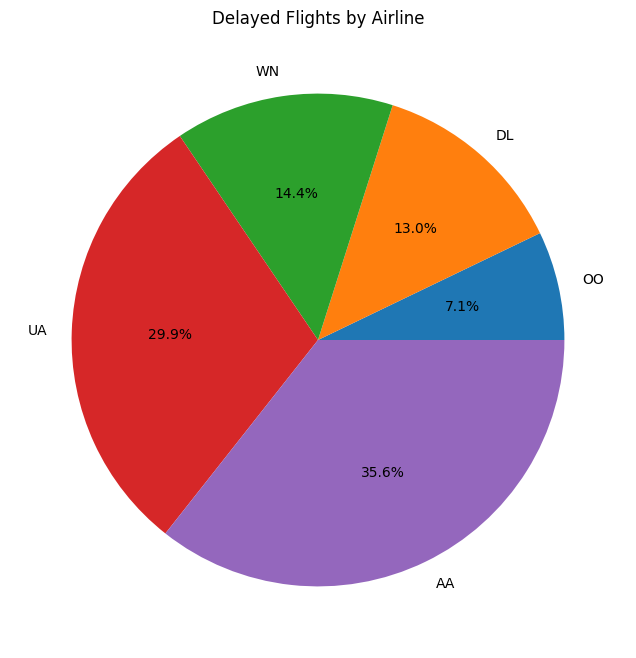

In [21]:
# pie chart of delayed flights by airline
delayed_flights = df.groupby("Reporting_Airline").sum("is_delay").orderBy("sum(is_delay)").toPandas()
plt.figure(figsize=(12, 8))

plt.pie(delayed_flights["sum(is_delay)"], labels=delayed_flights["Reporting_Airline"], autopct="%1.1f%%")
plt.title("Delayed Flights by Airline")
plt.show()


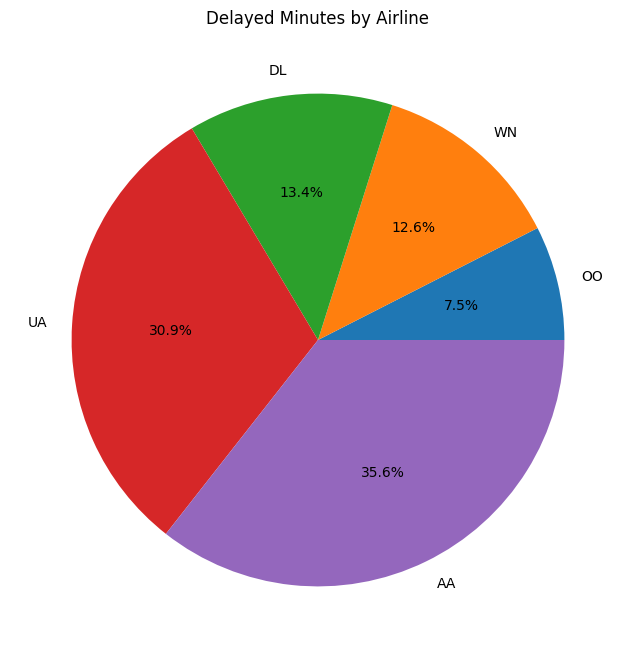

In [31]:
delayed_flights = (
    df.groupby("Reporting_Airline").sum("ArrDelayMinutes").orderBy("sum(ArrDelayMinutes)").toPandas()
)
plt.figure(figsize=(12, 8))

plt.pie(
    delayed_flights["sum(ArrDelayMinutes)"],
    labels=delayed_flights["Reporting_Airline"],
    autopct="%1.1f%%",
)
plt.title("Delayed Minutes by Airline")
plt.show()

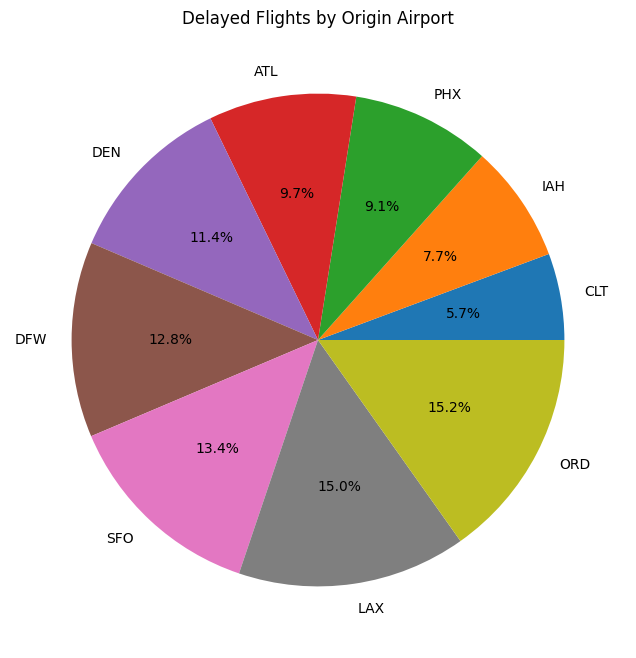

In [30]:
# delayed flights by airport
delayed_flights = df.groupby("Origin").sum("is_delay").orderBy("sum(is_delay)").toPandas()

plt.figure(figsize=(12, 8))
plt.pie(delayed_flights["sum(is_delay)"], labels=delayed_flights["Origin"], autopct="%1.1f%%")
plt.title("Delayed Flights by Origin Airport")
plt.show()

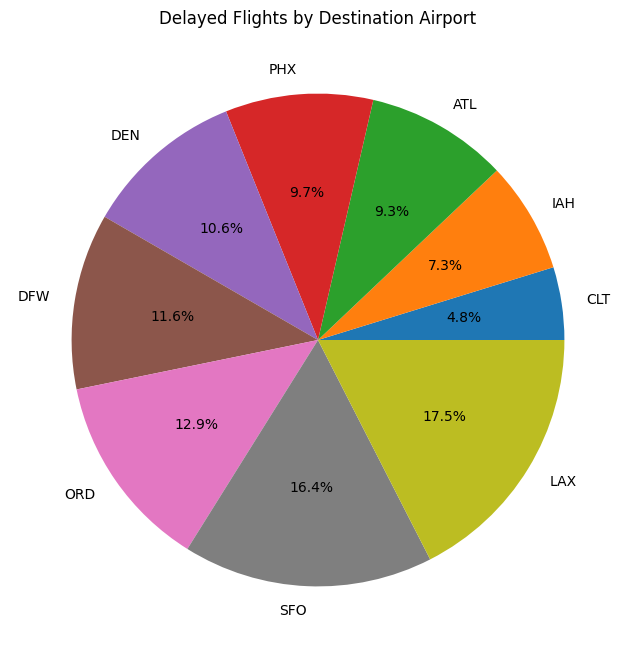

In [28]:
delayed_flights = (
    df.groupby("Dest").sum("is_delay").orderBy("sum(is_delay)").toPandas()
)

plt.figure(figsize=(12, 8))
plt.pie(
    delayed_flights["sum(is_delay)"],
    labels=delayed_flights["Dest"],
    autopct="%1.1f%%",
)
plt.title("Delayed Flights by Destination Airport")
plt.show()

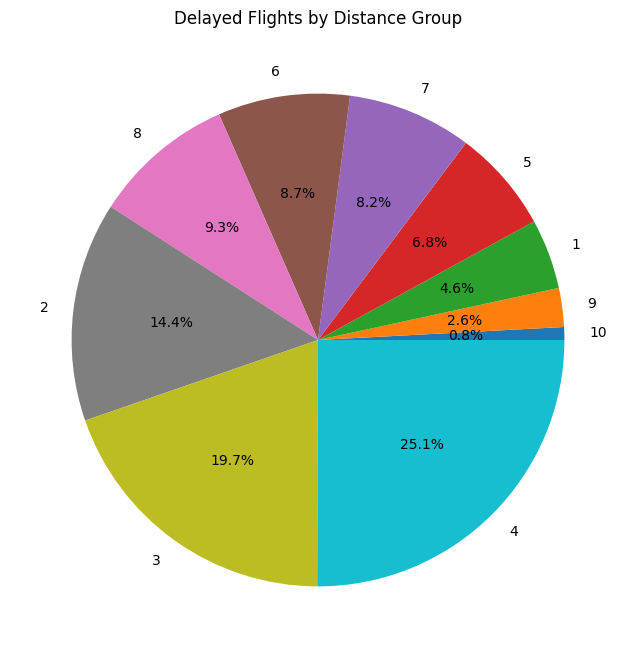

In [27]:
delayed_flights = (
    df.groupby("DistanceGroup").sum("is_delay").orderBy("sum(is_delay)").toPandas()
)

plt.figure(figsize=(12, 8))
plt.pie(
    delayed_flights["sum(is_delay)"],
    labels=delayed_flights["DistanceGroup"],
    autopct="%1.1f%%",
)
plt.title("Delayed Flights by Distance Group")
plt.show()